In [1]:
# WE WILL GET STARTED WITH USING THE TENSORFLOW AND KERAS LIBRARIES FOR OUR CNN ARCHITECTURE AND WE WILL BE USING THE FASHION_MNIST DATASET WHICH IS A MULTI-CLASS CLASSIFICATION 
# FIRST STEP WILL BE TO IMPORT ALL THE NECESSARY LIBRARIES i.e MATPLOTLIB, NUMPY, SKLEARN, NUMPY
# PANDAS WON'T BE NEEDED AS THERE WILL BE NO DATA CLEANING
# SKLEARN IS USED JUST FOR THE CLASSIFICATION REPORT WHICH CONTAINS EVALUATION METRICS LIKE F1_SCORE, ACCURACY, PRECISION, RECALL. 
import tensorflow as tf
import tensorflow as tf
from sklearn.metrics import accuracy_score

import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras import regularizers
import keras_tuner as kt

In [2]:
# NOW IT'S TIME TO TRAIN AND TEST OUR DATA. SO, WE DIVIDE OUR DATA INTO TRAIN AND TEST DATA BY USING THE BELOW COMMAND.
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# NOW FOR CONVINIENCE LET US NORMALIZE ALL THE PIXEL VALUES IN BETWEEN 0 AND 1 WHICH WILL BE EASY TO HANDLE.
train_images, test_images = train_images / 255.0, test_images / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


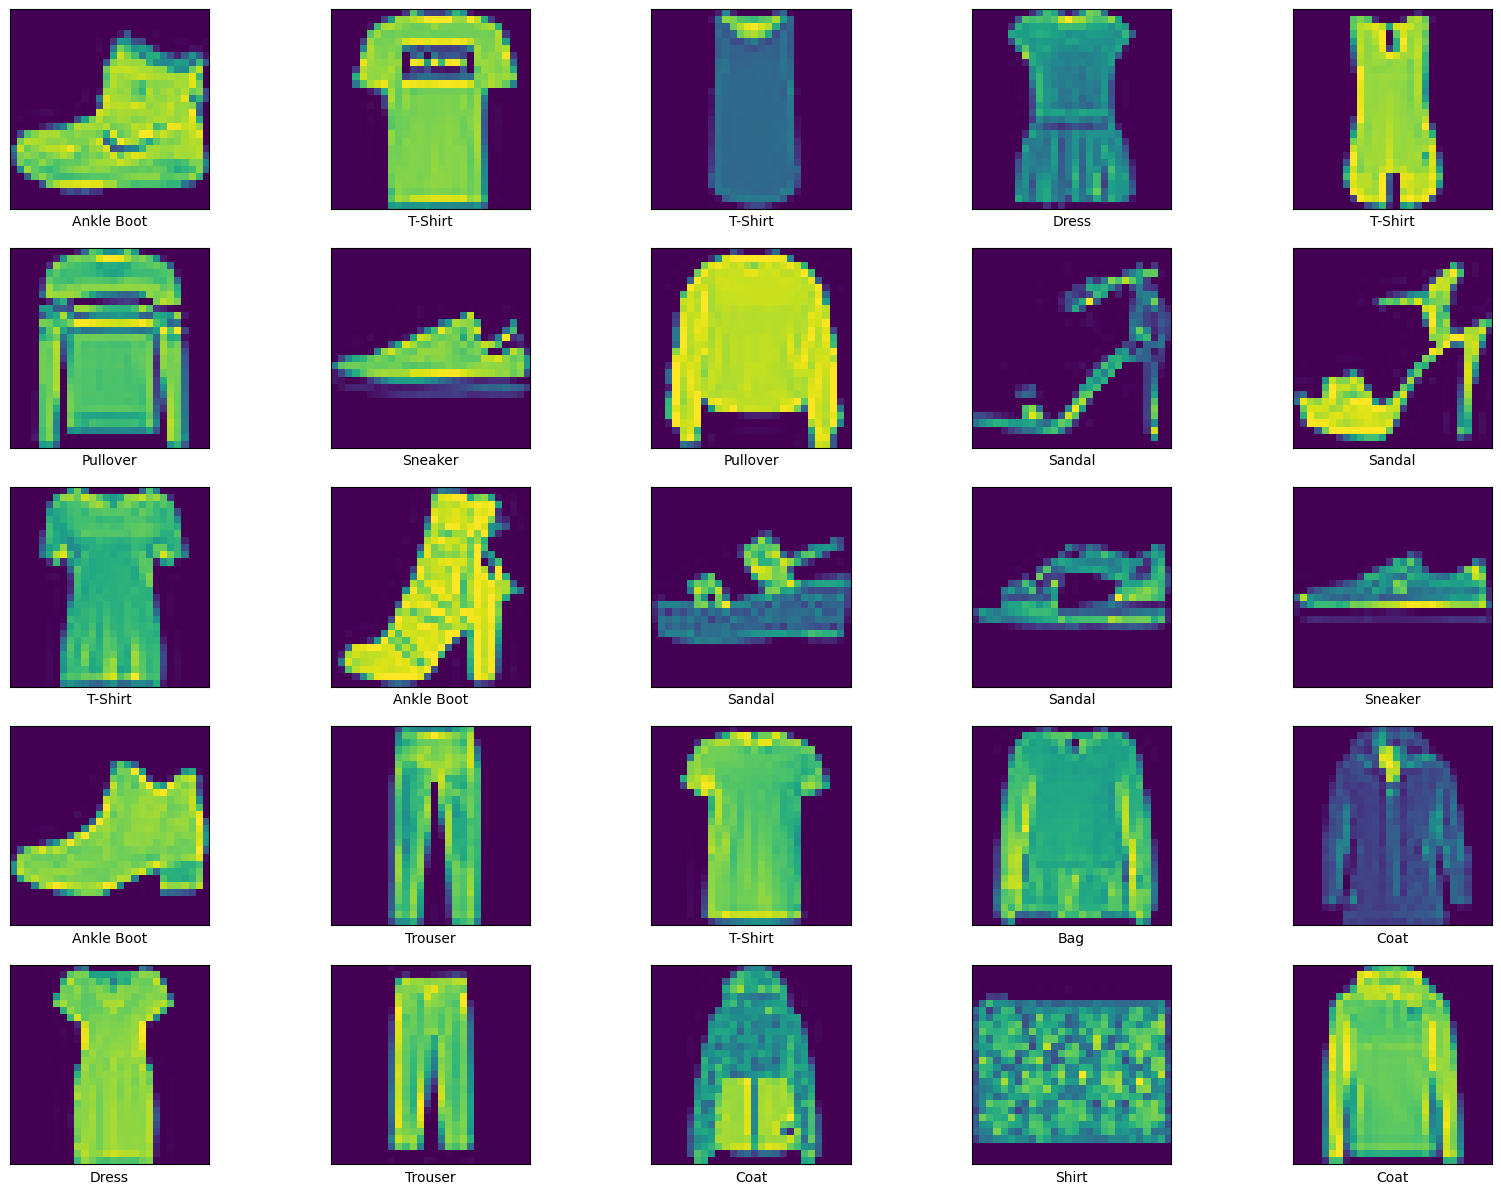

In [3]:
# THESE ARE THE DIFFERENT CLASSES THAT OUR DATASET CONTAINS.
class_names = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Bag', 'Sneaker', 'Shirt', 'Ankle Boot']
# USE MATPLOTLIB TO VIEW THE DATASET 
plt.figure(figsize=(20,15))   # MAKES A FIGURE OF SIZE 20 X 15
for i in range(25):           # FOR LOOP TO PLOT FIRST 25 IMAGES AT ALLOCATED POSITIONS
    plt.subplot(5,5,i+1)      # (5, 5, i+1)-->(ROWS, COLUMNS, CURRENT LOCATION OF SUBPLOT)
    plt.xticks([])            
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])    # DISPLAYS THE i-th IMAGE IN THE DATASET
    plt.xlabel(class_names[train_labels[i]])      # THIS DATASET IS A 1D-ARRAY DUE TO WHICH INDEXNG OF [0] IS NOT NECESSARY
plt.show()

In [4]:
# CNN IS A SEQUENTIAL MODEL AND NOW WE CREATE A SEQUENTIAL MODEL WHICH CONSISTS OF TOTAL 2 CONVOLUTION LAYES AND 1 MAX-POOLING LAYERS

model = models.Sequential()   # CREATING A SEQUENTIAL MODEL
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# SUMMARY OF THE MODEL WHICH CONTAINS THE PARAMETERS TRAINED
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,816 (73.50 KB)

 Trainable params: 18,816 (73.50 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# DEFINING A MODEL FOR HYPERTUNING WHICH CONSISTS OF DENSE LAYERS WHERE THE LEARNING OF PARAMETERS IS DONE AND COMPILING OF MODEL IS ALSO DONE.
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))  # CONVERSION FROM 2D TO 1D IS NECESSARY TO GO THROUGH THE DENSE LAYER
    model.add(
        layers.Dense(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            activation='relu',
            kernel_regularizer=regularizers.l2(0.01)
        )
    )
    model.add(                                                           # DROPOUT LAYER IS ADDED WHICH HELPS TO REDUCE THE OVERFITTING AND THE DROPOUT RATE IS A VARYING VALUE BETWEEN 0.1 AND 0.5 SO THAT HP.FLOAT CAN EXPLORE DIFFERENT RATES AND FIT FOR THE BEST           
        layers.Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))
    )
    model.add(layers.Dense(10))  # Output layer, 10 classes
    model.compile(
        optimizer=tf.keras.optimizers.Adam(                                            # OPTIMIZER ADJUSTS THE WEIGHTS IN THE FUNCTION AND EVALUATION OF METRICS (LIKE ACCURACY, LOSS) IS DONE.
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])        # LEARNING RATE IS ALSO GIVEN CHOICE FOR THE BEST VALUE TO FIT
        ),  
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [7]:
# DEFINING THE TUNING STRATEGY AND THE SEARCH SPACE.
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuning_dir',
    project_name='model_tuning'
    
)

# PREPARING THE DATA AND DIVIDING THEM INTO TEST AND TRAIN DATA.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# RUNNING THE TUNING PROCESS
tuner.search(
    train_images, train_labels,
    epochs=10,
    validation_split=0.2
)

# RETRIEVING THE BEST TUNING PARAMETERS
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best units: {best_hps.get('units')}
Best dropout: {best_hps.get('dropout')}
Best learning rate: {best_hps.get('learning_rate')}
""")

# TRAINING THE MODEL WITH BEST HYPERPARAMETERS
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_images, train_labels,
    epochs=10,
    validation_split=0.2
)

# EVALUATING THE MODEL ON THE TEST DATASET
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

Trial 30 Complete [00h 01m 06s]
val_accuracy: 0.9394166469573975

Best val_accuracy So Far: 0.9614999890327454
Total elapsed time: 00h 19m 58s

Best units: 192
Best dropout: 0.2
Best learning rate: 0.001

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8400 - loss: 1.2068 - val_accuracy: 0.9262 - val_loss: 0.4441
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9112 - loss: 0.4896 - val_accuracy: 0.9287 - val_loss: 0.4265
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9214 - loss: 0.4470 - val_accuracy: 0.9437 - val_loss: 0.3721
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9275 - loss: 0.4164 - val_accuracy: 0.9471 - val_loss: 0.3572
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9328 - loss: 0.3938 - val_accuracy: 0.9438 - val_loss: 0.3682
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9330 - loss: 0.3916 - val_accuracy: 0.9468 - val_loss: 0.3385
Epoch 7/10
1500

313/313 - 0s - 2ms/step - accuracy: 0.9530 - loss: 0.3070


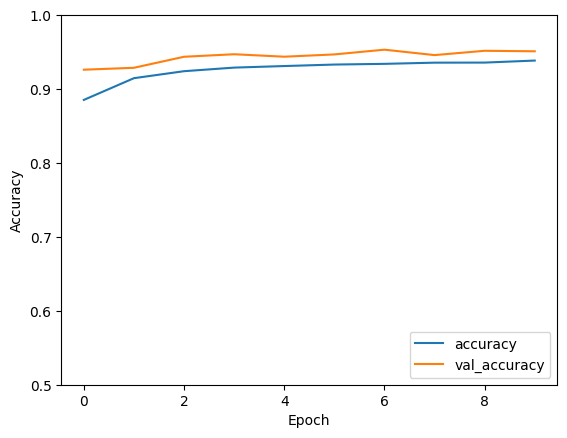

In [8]:
# PLOT TO EXPLAIN THE RELATION BETWEEN ACCURACY AND VAL_ACCURACY.
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


In [9]:
print(test_acc)

0.953000009059906


In [10]:
predictions = model.predict(test_images)

# CONVERT THE PROBABILITIES TO CLASS LABELS
# USE ARG MAX TO GET THE PREDICTED VALUES FOR THE MULTI CLASS CLASSIFICATION
predicted_labels = np.argmax(predictions, axis=1)

# GENERATING THE CLASSIFICATION REPORT
print(classification_report(test_labels, predicted_labels))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.96      0.96      1032
           3       0.97      0.94      0.95      1010
           4       0.97      0.94      0.95       982
           5       0.98      0.91      0.94       892
           6       0.91      0.98      0.95       958
           7       0.96      0.94      0.95      1028
           8       0.96      0.91      0.94       974
           9       0.91      0.96      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

